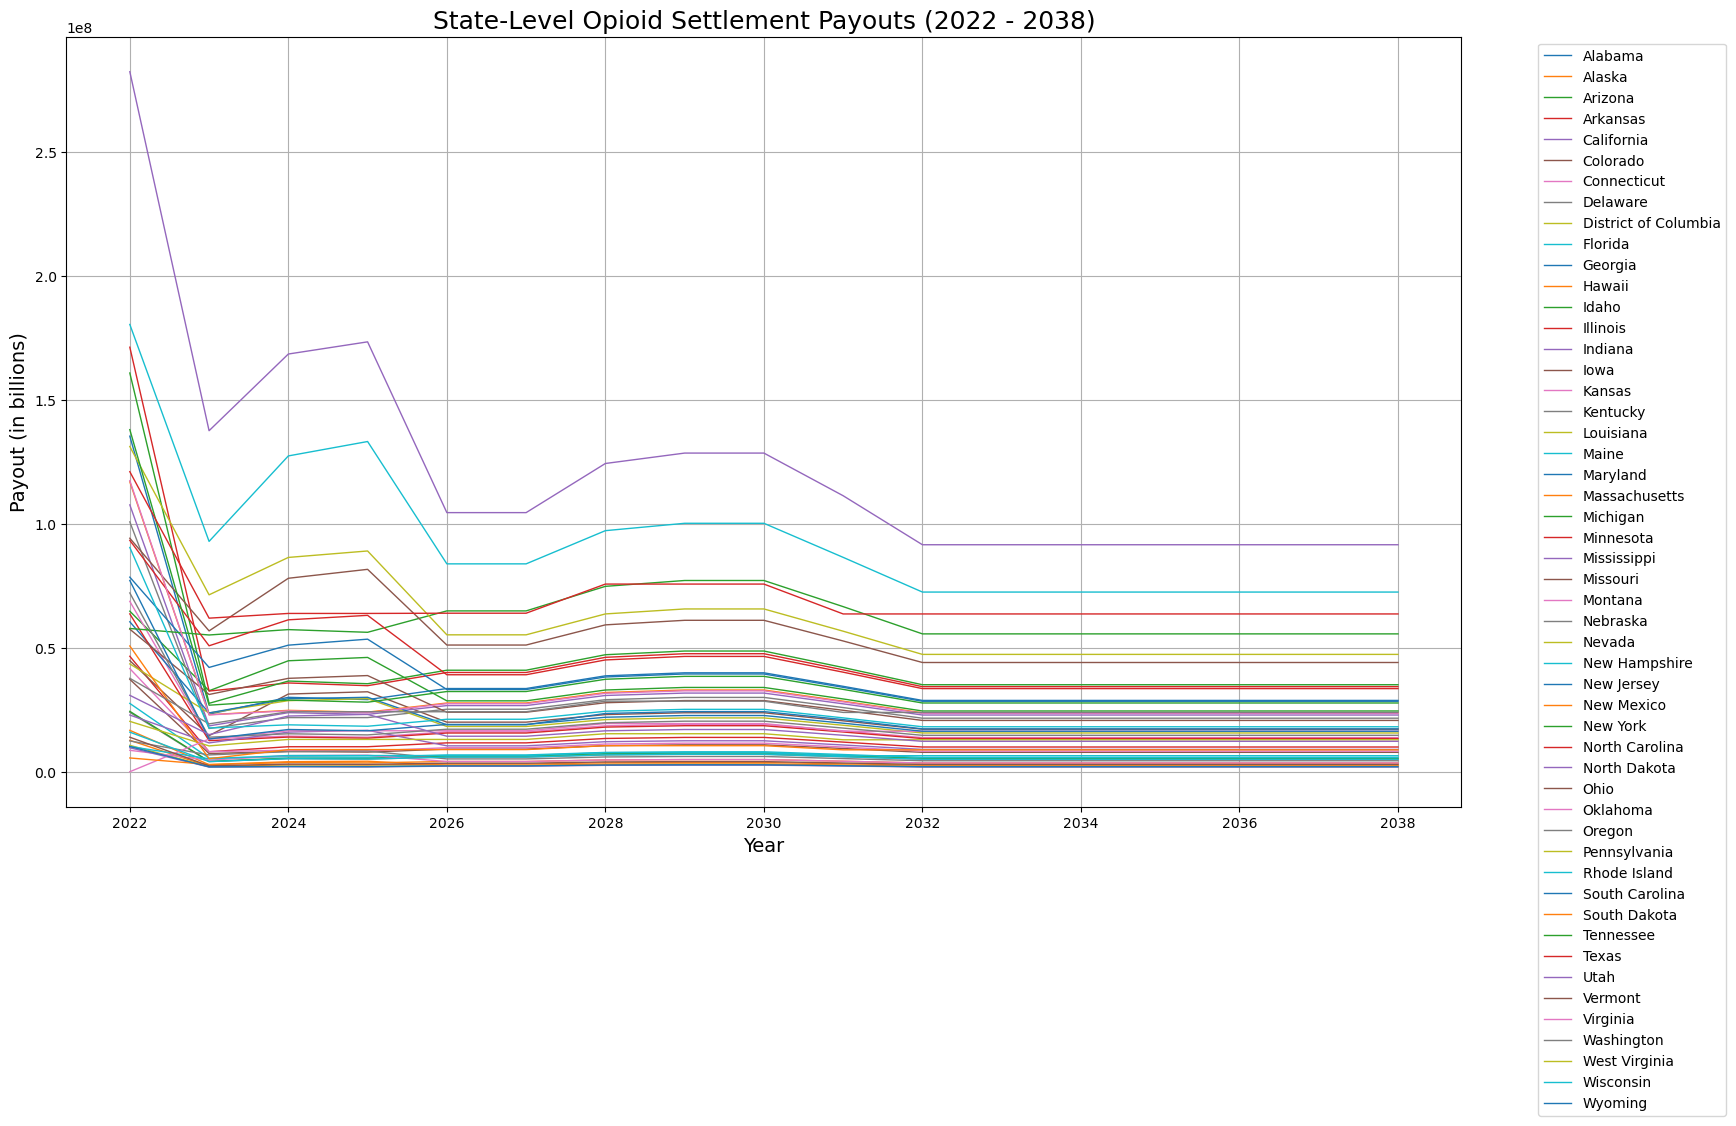

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = r'C:\Users\Daiki Sai\Downloads\Opioid-Settlement-Payouts-Data_040124.xlsx'
excel_file = pd.ExcelFile(file_path)
state_level_df = pd.read_excel(file_path, sheet_name='State-level')

state_names = state_level_df['name'].dropna().tolist()

years = list(range(2022, 2039))
payout_columns = [f"{year} settlement payout received" if year <= 2023 else f"{year} estimated future payout" for year in years]

state_payouts = state_level_df[payout_columns].transpose()
state_payouts.columns = state_names

# Plotting
plt.figure(figsize=(18, 10))

for state in state_names:
    plt.plot(years, state_payouts[state], label=state, linewidth=1)

plt.title('State-Level Opioid Settlement Payouts (2022 - 2038)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Payout (in billions)', fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()


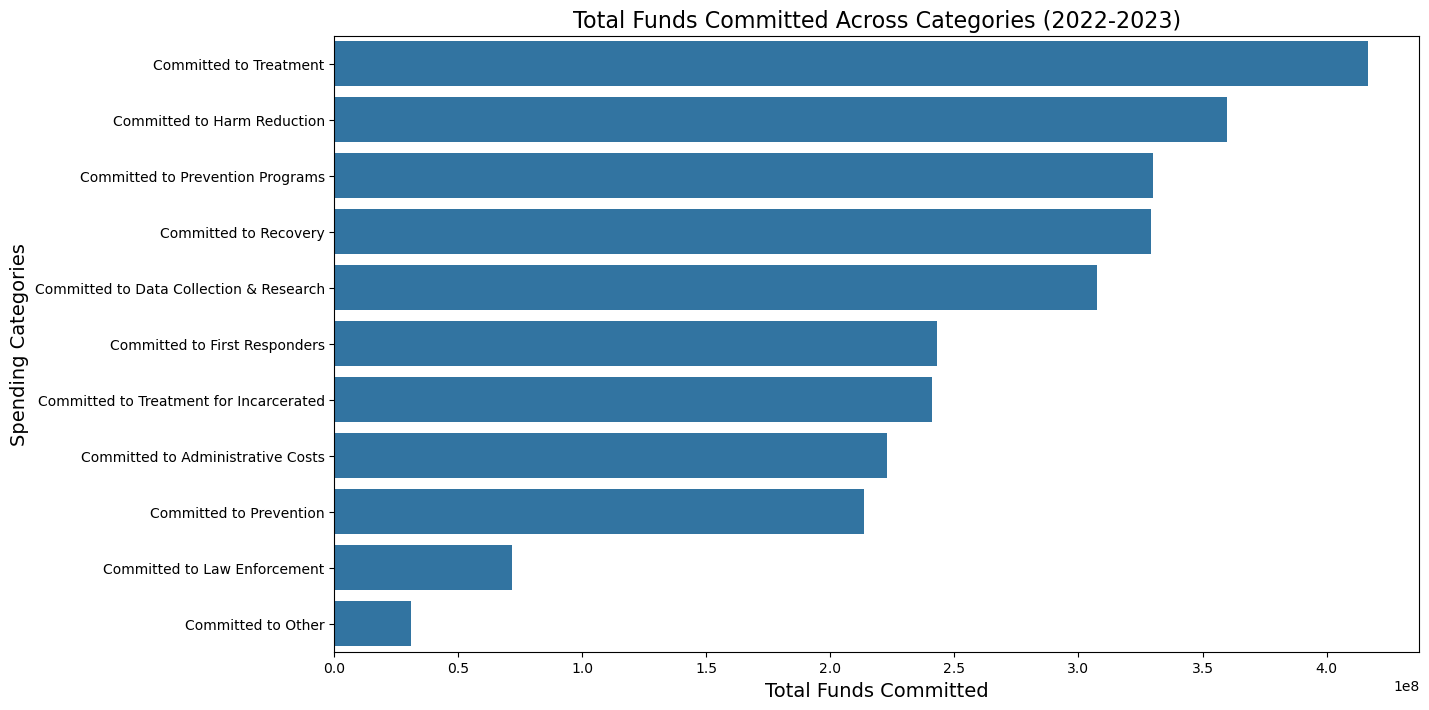

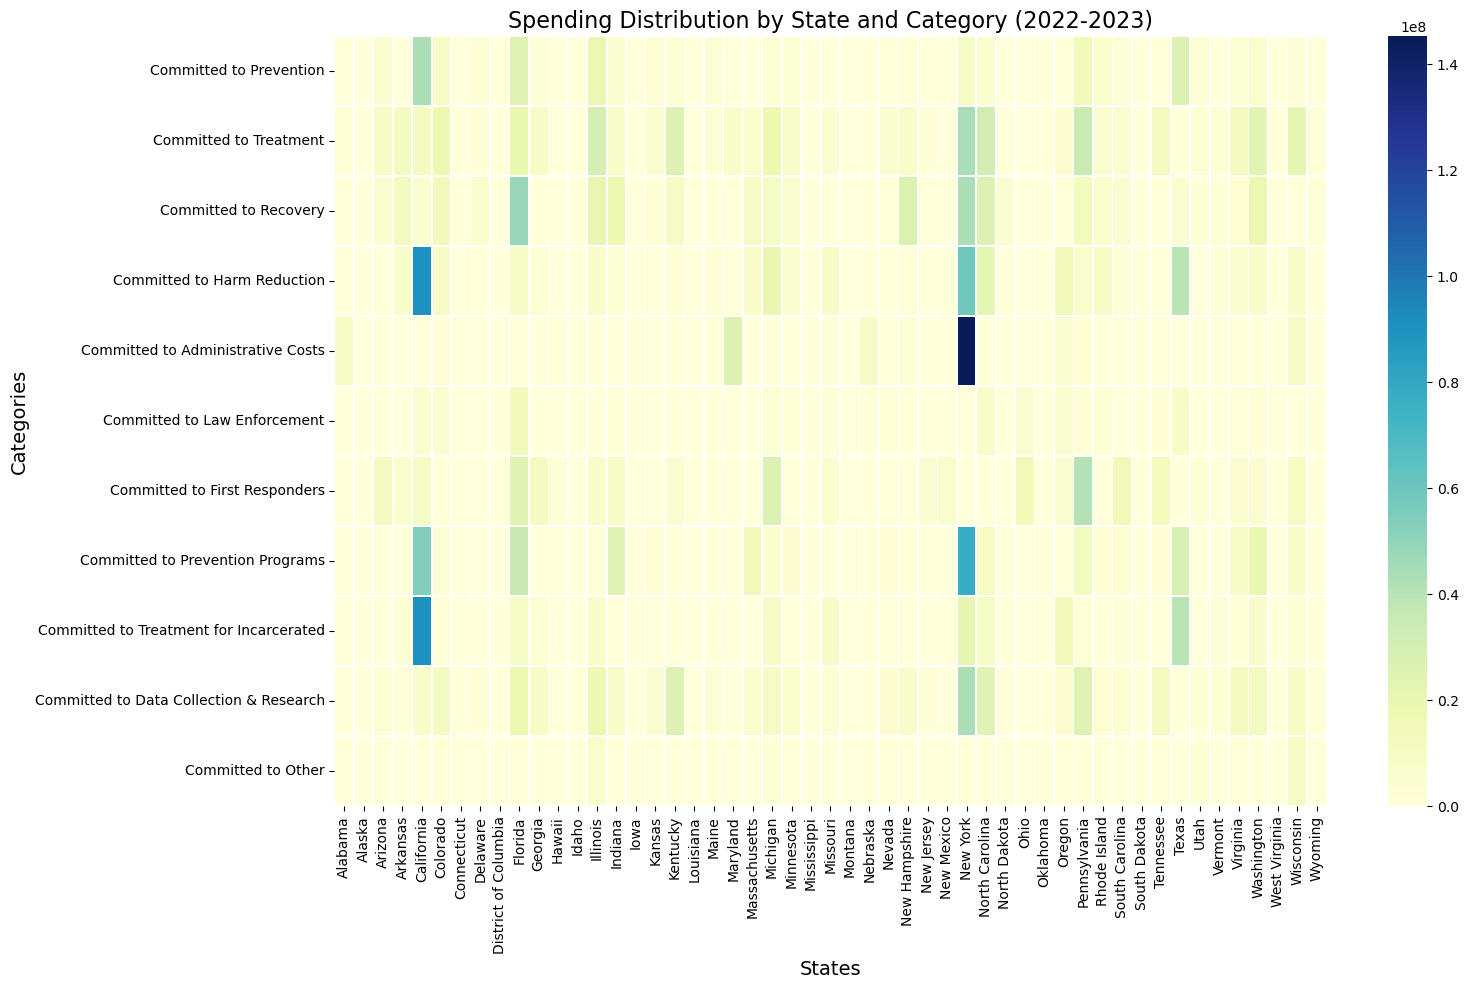

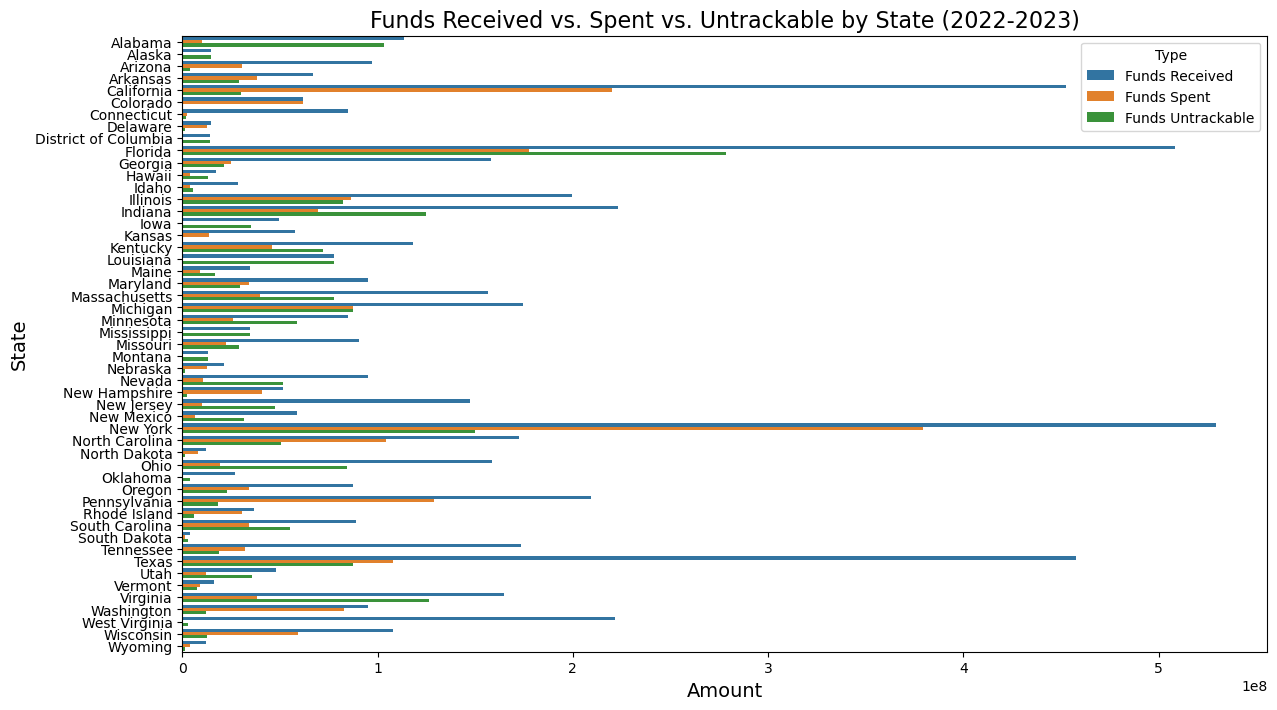

In [7]:
file_path_new = r'C:\Users\Daiki Sai\Downloads\opioid-settlement-expenditures-downloadable-data-121224-3.xlsx'
summary_data_df = pd.read_excel(file_path_new, sheet_name='Summary Data', skiprows=1)
summary_data_df = summary_data_df.iloc[:, :27]

# Rename columns
summary_data_df.columns = [
    'State', 'Funds Received', 'Funds Spent', 'Funds Set Aside', 'Funds Untrackable',
    'Committed to Prevention', '% Prevention', 'Committed to Treatment', '% Treatment',
    'Committed to Recovery', '% Recovery', 'Committed to Harm Reduction', '% Harm Reduction',
    'Committed to Administrative Costs', '% Administrative Costs',
    'Committed to Law Enforcement', '% Law Enforcement',
    'Committed to First Responders', '% First Responders',
    'Committed to Prevention Programs', '% Prevention Programs',
    'Committed to Treatment for Incarcerated', '% Treatment for Incarcerated',
    'Committed to Data Collection & Research', '% Data Collection & Research',
    'Committed to Other', '% Other'
]
summary_data_df = summary_data_df[summary_data_df['State'].notna()]


def visualize_spending_allocation():
    plt.figure(figsize=(14, 8))

    spending_columns = [
        'Committed to Prevention', 'Committed to Treatment', 'Committed to Recovery',
        'Committed to Harm Reduction', 'Committed to Administrative Costs',
        'Committed to Law Enforcement', 'Committed to First Responders',
        'Committed to Prevention Programs', 'Committed to Treatment for Incarcerated',
        'Committed to Data Collection & Research', 'Committed to Other'
    ]

    total_spending = summary_data_df[spending_columns].sum().sort_values(ascending=False)

    sns.barplot(x=total_spending.values, y=total_spending.index)
    plt.title('Total Funds Committed Across Categories (2022-2023)', fontsize=16)
    plt.xlabel('Total Funds Committed', fontsize=14)
    plt.ylabel('Spending Categories', fontsize=14)
    plt.show()


def visualize_spending_distribution():
    plt.figure(figsize=(16, 10))

    spending_data = summary_data_df[[
        'State', 'Committed to Prevention', 'Committed to Treatment', 'Committed to Recovery',
        'Committed to Harm Reduction', 'Committed to Administrative Costs',
        'Committed to Law Enforcement', 'Committed to First Responders',
        'Committed to Prevention Programs', 'Committed to Treatment for Incarcerated',
        'Committed to Data Collection & Research', 'Committed to Other'
    ]]

    spending_data = spending_data.set_index('State').T

    sns.heatmap(spending_data, cmap='YlGnBu', linewidths=.5)
    plt.title('Spending Distribution by State and Category (2022-2023)', fontsize=16)
    plt.xlabel('States', fontsize=14)
    plt.ylabel('Categories', fontsize=14)
    plt.show()


def visualize_funds_received_vs_spent():
    plt.figure(figsize=(14, 8))

    funds_received_spent = summary_data_df[['State', 'Funds Received', 'Funds Spent', 'Funds Untrackable']]
    funds_received_spent = funds_received_spent.melt(id_vars='State', var_name='Type', value_name='Amount')

    sns.barplot(x='Amount', y='State', hue='Type', data=funds_received_spent)
    plt.title('Funds Received vs. Spent vs. Untrackable by State (2022-2023)', fontsize=16)
    plt.xlabel('Amount', fontsize=14)
    plt.ylabel('State', fontsize=14)
    plt.legend(title='Type')
    plt.show()


# Call functions to visualize
visualize_spending_allocation()
visualize_spending_distribution()
visualize_funds_received_vs_spent()

In [10]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np


file_path_ads = r"C:\Users\Daiki Sai\Downloads\deduplicated_opioid_ads.csv"
ads_df = pd.read_csv(file_path_ads, usecols=['ad_archive_id', 'snapshot/title'])
ads_df.dropna(subset=['snapshot/title'], inplace=True)


#Method 1: Keyword Matching
categories = {
    'Prevention': ['prevent', 'awareness', 'education', 'campaign', 'initiative'],
    'Treatment': ['treatment', 'therapy', 'rehab', 'clinic', 'recovery'],
    'Recovery': ['recovery', 'support group', 'counseling', 'sobriety'],
    'Harm Reduction': ['harm reduction', 'naloxone', 'syringe', 'overdose prevention'],
    'Administrative Costs': ['administrative', 'management', 'costs', 'budget'],
    'Law Enforcement': ['law enforcement', 'police', 'crime', 'justice'],
    'First Responders': ['first responder', 'emergency', 'paramedic', '911'],
    'Prevention Programs': ['prevention program', 'education program', 'awareness program'],
    'Treatment for Incarcerated': ['incarcerated', 'prison', 'jail', 'inmate'],
    'Data Collection & Research': ['research', 'data', 'study', 'survey'],
    'Other': ['other', 'miscellaneous']
}


def keyword_matching(text):
    text = text.lower()
    for category, keywords in categories.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Uncategorized'


ads_df['Category_Keyword'] = ads_df['snapshot/title'].apply(keyword_matching)


#Method 2: TF-IDF + Clustering 
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(ads_df['snapshot/title'])

# Using KMeans to cluster ads
num_clusters = 11  # Assuming the same number of categories as above
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
ads_df['Category_Clustering'] = kmeans.fit_predict(X)


# Method 3: Supervised Machine Learning
# Prepare labeled data for training (Example, needs real labeled data)
label_mapping = {category: i for i, category in enumerate(categories.keys())}
ads_df['Label'] = ads_df['Category_Keyword'].map(label_mapping)

# Drop rows where label is not found
labeled_data = ads_df.dropna(subset=['Label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    labeled_data['snapshot/title'], labeled_data['Label'], test_size=0.2, random_state=42
)

vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a Logistic Regression model
model = LogisticRegression(max_iter=200)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)


unique_labels = np.unique(y_test).astype(int)

# Generate the filtered categories
filtered_categories = [list(categories.keys())[i] for i in unique_labels if i in range(len(categories))]

# Generate classification report with filtered categories
report = classification_report(y_test, y_pred, target_names=filtered_categories)
print(report)

C:\Users\Daiki Sai\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                            precision    recall  f1-score   support

                 Treatment       0.98      1.00      0.99        57
            Harm Reduction       1.00      1.00      1.00         1
      Administrative Costs       1.00      1.00      1.00         1
Data Collection & Research       1.00      0.92      0.96        13

                  accuracy                           0.99        72
                 macro avg       1.00      0.98      0.99        72
              weighted avg       0.99      0.99      0.99        72



Deaths DataFrame columns: Index(['YEAR', 'STATE', 'RATE', 'DEATHS', 'URL'], dtype='object')
   YEAR STATE  RATE  DEATHS                                       URL
0  2022    AL  31.5    1492     /nchs/pressroom/states/alabama/al.htm
1  2022    AK  34.3     254      /nchs/pressroom/states/alaska/ak.htm
2  2022    AZ  37.2    2664     /nchs/pressroom/states/arizona/az.htm
3  2022    AR  21.7     617    /nchs/pressroom/states/arkansas/ar.htm
4  2022    CA  26.9   10952  /nchs/pressroom/states/california/ca.htm
Payouts DataFrame columns: Index(['name', '2022 settlement payout received',
       '2023 settlement payout received', '2024 estimated future payout',
       '2025 estimated future payout', '2026 estimated future payout',
       '2027 estimated future payout', '2028 estimated future payout',
       '2029 estimated future payout', '2030 estimated future payout',
       '2031 estimated future payout', '2032 estimated future payout',
       '2033 estimated future payout', '2034 estimate

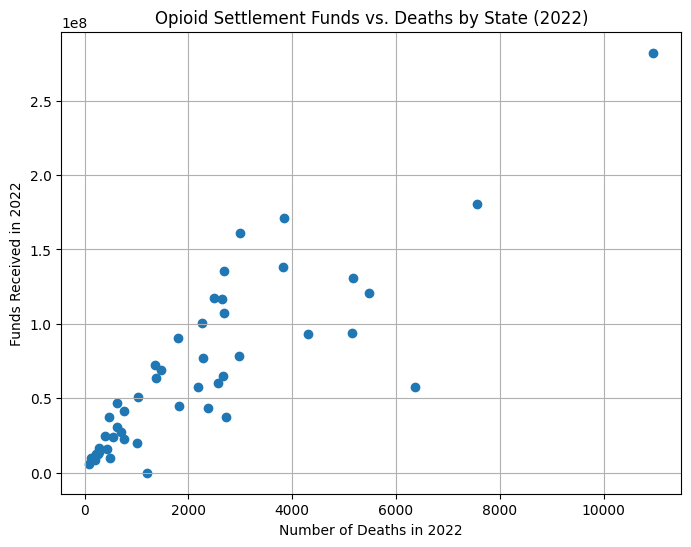

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

us_state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Load the CSV file (assuming it contains the 2022 opioid death counts by state)
csv_path = r"C:\Users\Daiki Sai\Downloads\data-table (2).csv"
deaths_df = pd.read_csv(csv_path)

# Load the second sheet of the Excel file (which has the opioid settlement payout data)
excel_path = r"C:\Users\Daiki Sai\Downloads\Opioid-Settlement-Payouts-Data_040124.xlsx"
payouts_df = pd.read_excel(excel_path, sheet_name=1)  # sheet_name=1 selects the second sheet

# Inspect the first few rows and column names to verify the structure
print("Deaths DataFrame columns:", deaths_df.columns)
print(deaths_df.head())

print("Payouts DataFrame columns:", payouts_df.columns)
print(payouts_df.head())

deaths_df['STATE'] = deaths_df['STATE'].str.strip().map(us_state_abbrev)

# Clean the payouts state column, assuming it contains full names.
# We use .str.strip() and .str.title() to ensure consistency.
payouts_df['name'] = payouts_df['name'].str.strip().str.title()

# (Optional) Rename columns to have common names, if needed.
# For example, if your CSV column for deaths is "Deaths in 2022", you can rename it:
deaths_2022_df = deaths_df[deaths_df['YEAR'] == 2022]
# And if your payouts column for funds is different, rename accordingly:
# payouts_df = payouts_df.rename(columns={'Payout Amount 2022': 'Funds_2022'})

# Now merge the two datasets on the State column.
merged_df = pd.merge(deaths_2022_df, payouts_df, left_on="STATE", right_on = "name", how="inner")

# Display the first few rows of the merged dataset.
print(merged_df.head())

# (Optional) Create a scatter plot to visualize the relationship.
plt.figure(figsize=(8, 6))
plt.scatter(merged_df["DEATHS"], merged_df["2022 settlement payout received"])
plt.xlabel("Number of Deaths in 2022")
plt.ylabel("Funds Received in 2022")
plt.title("Opioid Settlement Funds vs. Deaths by State (2022)")
plt.grid(True)
plt.show()

In [10]:
subset_df = payouts_df[['name', '2022 settlement payout received']]
# Create the top 5 DataFrame by sorting in descending order on the payout column.
top5_df = subset_df.sort_values(by="2022 settlement payout received", ascending=False).head(5)

# Create the bottom 5 DataFrame by sorting in ascending order on the payout column.
bottom5_df = subset_df.sort_values(by="2022 settlement payout received", ascending=True).head(5)

# Display the two DataFrames.
print("Top 5 states with the most funds received:")
print(top5_df.to_string(index=False))
print("\nBottom 5 states with the least funds received:")
print(bottom5_df.to_string(index=False))

Top 5 states with the most funds received:
      name  2022 settlement payout received
California                     282165225.08
   Florida                     180292401.62
  Illinois                     171123124.29
  Michigan                     160725070.99
 Tennessee                     137900618.76

Bottom 5 states with the least funds received:
        name  2022 settlement payout received
    Oklahoma                             0.00
South Dakota                       5547788.00
     Montana                       8629527.94
North Dakota                       9659320.58
     Wyoming                      10158364.93


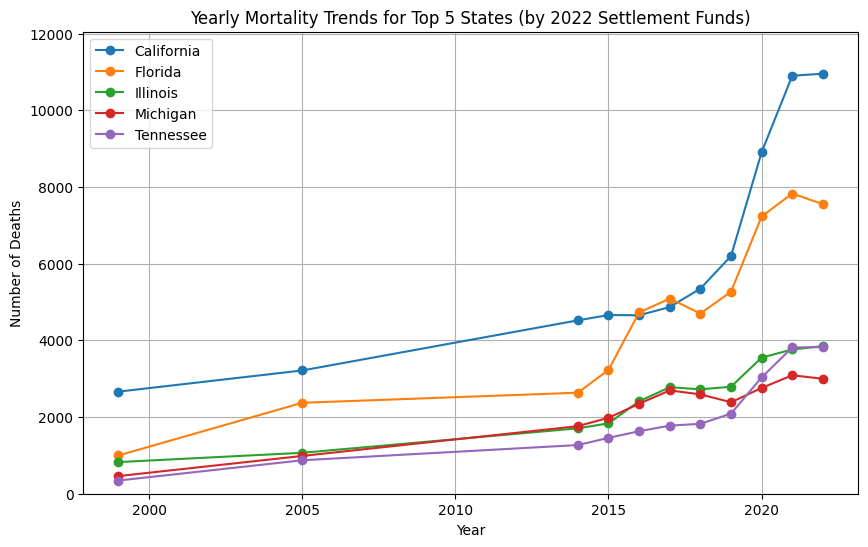

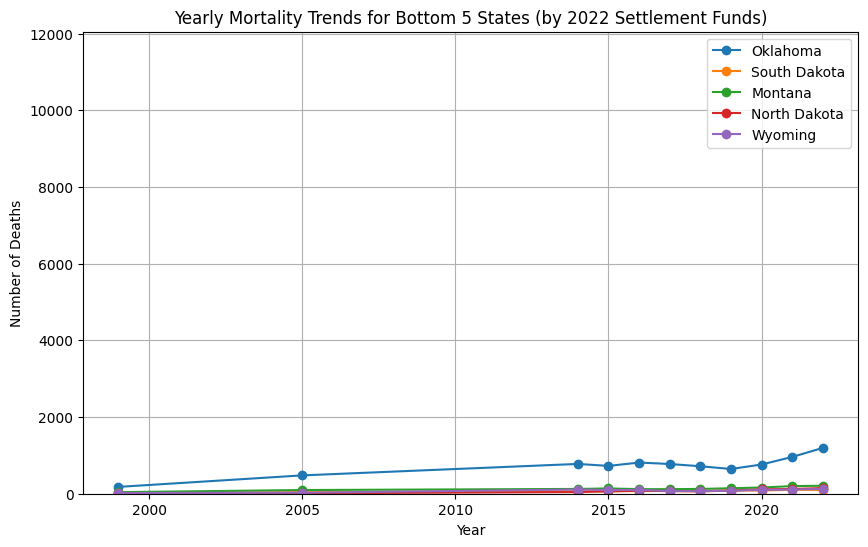

In [39]:
# # Extract lists of state names from the top5 and bottom5 data.
# top5_states = top5_df['name'].tolist()
# bottom5_states = bottom5_df['name'].tolist()

# # Plot line graph for the top 5 states.
# plt.figure(figsize=(10, 6))
# for state in top5_states:
#     # Filter the full deaths data (all years) for the current state.
#     state_data = deaths_df[deaths_df['STATE'] == state]
#     # Group by year and sum deaths (in case there are multiple records per year).
#     yearly_data = state_data.groupby('YEAR')['DEATHS'].sum().reset_index()
#     plt.plot(yearly_data['YEAR'], yearly_data['DEATHS'], marker='o', label=state)
# plt.title("Yearly Mortality Trends for Top 5 States (by 2022 Settlement Funds)")
# plt.xlabel("Year")
# plt.ylabel("Number of Deaths")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot line graph for the bottom 5 states.
# plt.figure(figsize=(10, 6))
# for state in bottom5_states:
#     state_data = deaths_df[deaths_df['STATE'] == state]
#     yearly_data = state_data.groupby('YEAR')['DEATHS'].sum().reset_index()
#     plt.plot(yearly_data['YEAR'], yearly_data['DEATHS'], marker='o', label=state)
# plt.title("Yearly Mortality Trends for Bottom 5 States (by 2022 Settlement Funds)")
# plt.xlabel("Year")
# plt.ylabel("Number of Deaths")
# plt.legend()
# plt.grid(True)
# plt.show()

# Combine top and bottom states to calculate global y-axis limits
all_states = top5_states + bottom5_states
all_deaths = []

for state in all_states:
    state_data = deaths_df[deaths_df['STATE'] == state]
    yearly_data = state_data.groupby('YEAR')['DEATHS'].sum().reset_index()
    all_deaths.extend(yearly_data['DEATHS'].values)

# Compute global min and max for y-axis
y_min = 0
y_max = max(all_deaths) * 1.1  # Add 10% buffer for visual clarity

# Plot for top 5 states
plt.figure(figsize=(10, 6))
for state in top5_states:
    state_data = deaths_df[deaths_df['STATE'] == state]
    yearly_data = state_data.groupby('YEAR')['DEATHS'].sum().reset_index()
    plt.plot(yearly_data['YEAR'], yearly_data['DEATHS'], marker='o', label=state)

plt.title("Yearly Mortality Trends for Top 5 States (by 2022 Settlement Funds)")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.ylim(y_min, y_max)
plt.legend()
plt.grid(True)
plt.show()

# Plot for bottom 5 states
plt.figure(figsize=(10, 6))
for state in bottom5_states:
    state_data = deaths_df[deaths_df['STATE'] == state]
    yearly_data = state_data.groupby('YEAR')['DEATHS'].sum().reset_index()
    plt.plot(yearly_data['YEAR'], yearly_data['DEATHS'], marker='o', label=state)

plt.title("Yearly Mortality Trends for Bottom 5 States (by 2022 Settlement Funds)")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.ylim(y_min, y_max)
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Load your dataset (Update the path to your CSV file)
file_path = r"C:\Users\Daiki Sai\Downloads\FacebookOpioidData.csv"
df = pd.read_csv(file_path)

# Extract the relevant column
if 'snapshot/body/text' in df.columns:
    text_df = df[['snapshot/body/text']].copy()
    text_df.rename(columns={'snapshot/body/text': 'text'}, inplace=True)
else:
    raise ValueError("The column 'snapshot/body/text' does not exist in the dataset.")

# Remove null or empty rows
text_df = text_df.dropna(subset=['text'])
text_df = text_df[text_df['text'].astype(str).str.strip() != '']

# Ensure all text data is converted to string type
text_df['text'] = text_df['text'].astype(str)

# Vectorize the text data using CountVectorizer (Bag of Words approach)
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(text_df['text'])

# Initialize LDA model
num_topics = 4  # Number of categories to identify (Treatment, Prevention, Recovery, Awareness)
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Get the topics and their keywords
words = vectorizer.get_feature_names_out()
topics = {}

for index, topic in enumerate(lda.components_):
    topics[f"Topic {index+1}"] = [words[i] for i in topic.argsort()[-10:]]

# Print the topics with their keywords
for topic, keywords in topics.items():
    print(f"\n{topic}: {', '.join(keywords)}")

# Assign the most likely topic to each ad description
topic_assignments = lda.transform(X).argmax(axis=1)
text_df['Category'] = [f'Topic {i+1}' for i in topic_assignments]

# Save the categorized data to a new CSV file
output_file = 'unsupervised_categorized_opioid_ads.csv'
text_df.to_csv(output_file, index=False)
print(f"✅ Categorized data saved to '{output_file}'.")



Topic 1: limited, time, spinal, proven, clinically, sciatica, relief, disc, surgery, pain

Topic 2: overdose, learn, today, use, health, recovery, addiction, opioid, product, brand

Topic 3: surgical, support, new, help, free, non, opioid, treatment, knee, pain

Topic 4: real, invest, copa, change, lives, time, treatment, medication, opioid, pain
✅ Categorized data saved to 'unsupervised_categorized_opioid_ads.csv'.


In [14]:
print(text_df)

                                                  text Category
0    Kolbe Clinic is an outpatient behavioral healt...  Topic 4
1    The opioid epidemic had separated too many fam...  Topic 3
2    This story only gets crazier! Subscribe to my ...  Topic 2
3    This story only gets crazier! Subscribe to my ...  Topic 2
4    We are raising funds additional to our Ballist...  Topic 2
..                                                 ...      ...
861      Opioid and Alcohol Addiction Treatment Center  Topic 2
862      Opioid and Alcohol Addiction Treatment Center  Topic 2
863      Opioid and Alcohol Addiction Treatment Center  Topic 2
864  Clinical evaluation will be conducted in Ander...  Topic 3
865  This Treatment Really Works! We Successfully T...  Topic 4

[854 rows x 2 columns]


In [15]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# Load your dataset (Update the path to your CSV file)
file_path = r"C:\Users\Daiki Sai\Downloads\FacebookOpioidData.csv"
df = pd.read_csv(file_path)

# Extract the relevant column
if 'snapshot/body/text' in df.columns:
    text_df = df[['snapshot/body/text']].copy()
    text_df.rename(columns={'snapshot/body/text': 'text'}, inplace=True)
else:
    raise ValueError("The column 'snapshot/body/text' does not exist in the dataset.")

# Remove null or empty rows
text_df = text_df.dropna(subset=['text'])
text_df = text_df[text_df['text'].astype(str).str.strip() != '']

# Ensure all text data is converted to string type
text_df['text'] = text_df['text'].astype(str)

# Load a pre-trained Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2')  # You can also try 'paraphrase-MiniLM-L6-v2' or other models

# Convert text data to embeddings
embeddings = model.encode(text_df['text'].tolist(), show_progress_bar=True)

# Perform clustering using K-Means
num_clusters = 4  # You can change this depending on how many categories you want to extract
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
text_df['Category'] = kmeans.fit_predict(embeddings)

# Print top words per cluster
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract keywords for each cluster
for cluster_num in range(num_clusters):
    cluster_texts = text_df[text_df['Category'] == cluster_num]['text']
    vectorizer = TfidfVectorizer(stop_words='english', max_features=10)
    tfidf_matrix = vectorizer.fit_transform(cluster_texts)
    top_keywords = vectorizer.get_feature_names_out()
    print(f"\nCluster {cluster_num} Keywords: {', '.join(top_keywords)}")

# Save the categorized data to a new CSV file
output_file = 'sentence_transformers_categorized_opioid_ads.csv'
text_df.to_csv(output_file, index=False)
print(f"✅ Categorized data saved to '{output_file}'.")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\Daiki Sai\miniconda3\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Daiki Sai\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

C:\Users\Daiki Sai\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Daiki Sai\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(



Cluster 0 Keywords: biometrics, copa, invest, minutes, monitoring, opioid, overdose, real, saving, time

Cluster 1 Keywords: brand, product

Cluster 2 Keywords: chronic, disc, pain, patients, proven, relief, sciatica, surgery, time, treatment

Cluster 3 Keywords: addiction, health, help, learn, opioid, recovery, support, today, treatment, use
✅ Categorized data saved to 'sentence_transformers_categorized_opioid_ads.csv'.


In [29]:
import pandas as pd

# Load the overdose data
overdose_file_path = r"C:\Users\Daiki Sai\Downloads\VSRR_Provisional_Drug_Overdose_Death_Counts.csv"
overdose_df = pd.read_csv(overdose_file_path)

# Load the funds per state data from Excel file (State-level sheet)
funds_file_path = r"C:\Users\Daiki Sai\Downloads\Opioid-Settlement-Payouts-Data_040124.xlsx"
funds_state_df = pd.read_excel(funds_file_path, sheet_name='State-level')

# Filter the overdose data to include only the relevant indicator: "Opioids (T40.0-T40.4,T40.6)"
filtered_overdose_df = overdose_df[overdose_df['Indicator'] == "Opioids (T40.0-T40.4,T40.6)"]

# Convert 'Data Value' to numeric, forcing errors to NaN
filtered_overdose_df['Data Value'] = pd.to_numeric(filtered_overdose_df['Data Value'], errors='coerce')

# Remove rows where 'Data Value' is NaN (i.e., non-numeric)
#filtered_overdose_df = filtered_overdose_df.dropna(subset=['Data Value'])


# Aggregate the overdose data by state and year, calculating the total number of deaths
overdose_summary = filtered_overdose_df.groupby(['State Name', 'Year'])['Data Value'].sum().reset_index()
overdose_summary.columns = ['State Name', 'Year', 'Total Overdose Deaths']

# Standardize state names in the settlement data
funds_state_df['name'] = funds_state_df['name'].str.strip()

print(filtered_overdose_df[filtered_overdose_df['State Name'] == 'Georgia'])

# Filter the settlement data to only include the 2022 payout
funds_2022_df = funds_state_df[['name', '2022 settlement payout received']].copy()
funds_2022_df.columns = ['State Name', '2022 Settlement Payout']

# Merge the overdose summary with the 2022 settlement data
merged_df = pd.merge(overdose_summary, funds_2022_df, on='State Name', how='inner')

# Save the merged data to a new CSV file
output_file = 'merged_funds_overdose_data.csv'
merged_df.to_csv(output_file, index=False)

# Display completion message
print(f"✅ Merged data saved to '{output_file}'.")

      State  Year      Month           Period                    Indicator  \
13106    GA  2015      April  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
13112    GA  2015     August  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
13125    GA  2015   December  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
13138    GA  2015   February  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
13153    GA  2015    January  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
...     ...   ...        ...              ...                          ...   
14462    GA  2024       June  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
14468    GA  2024      March  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
14489    GA  2024        May  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
14495    GA  2024    October  12 month-ending  Opioids (T40.0-T40.4,T40.6)   
14507    GA  2024  September  12 month-ending  Opioids (T40.0-T40.4,T40.6)   

       Data Value  Percent Complete  Percent Pending Investigat

C:\conda_tmp\ipykernel_3416\2452489968.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_overdose_df['Data Value'] = pd.to_numeric(filtered_overdose_df['Data Value'], errors='coerce')


In [34]:
print(merged_df[merged_df['State Name'] == 'California'])

    State Name  Year  Total Overdose Deaths  2022 Settlement Payout
40  California  2015                    0.0            2.821652e+08
41  California  2016                    0.0            2.821652e+08
42  California  2017                    0.0            2.821652e+08
43  California  2018                    0.0            2.821652e+08
44  California  2019                    0.0            2.821652e+08
45  California  2020                    0.0            2.821652e+08
46  California  2021                    0.0            2.821652e+08
47  California  2022                    0.0            2.821652e+08
48  California  2023                    0.0            2.821652e+08
49  California  2024                    0.0            2.821652e+08


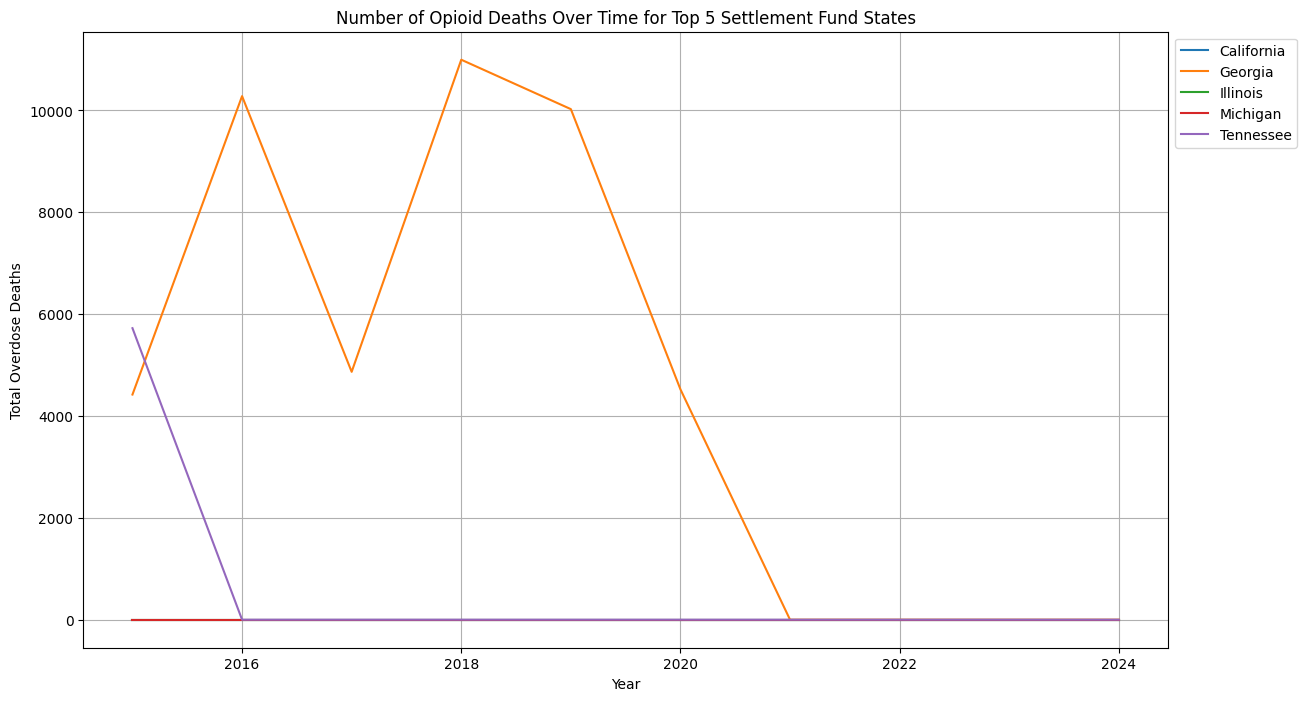

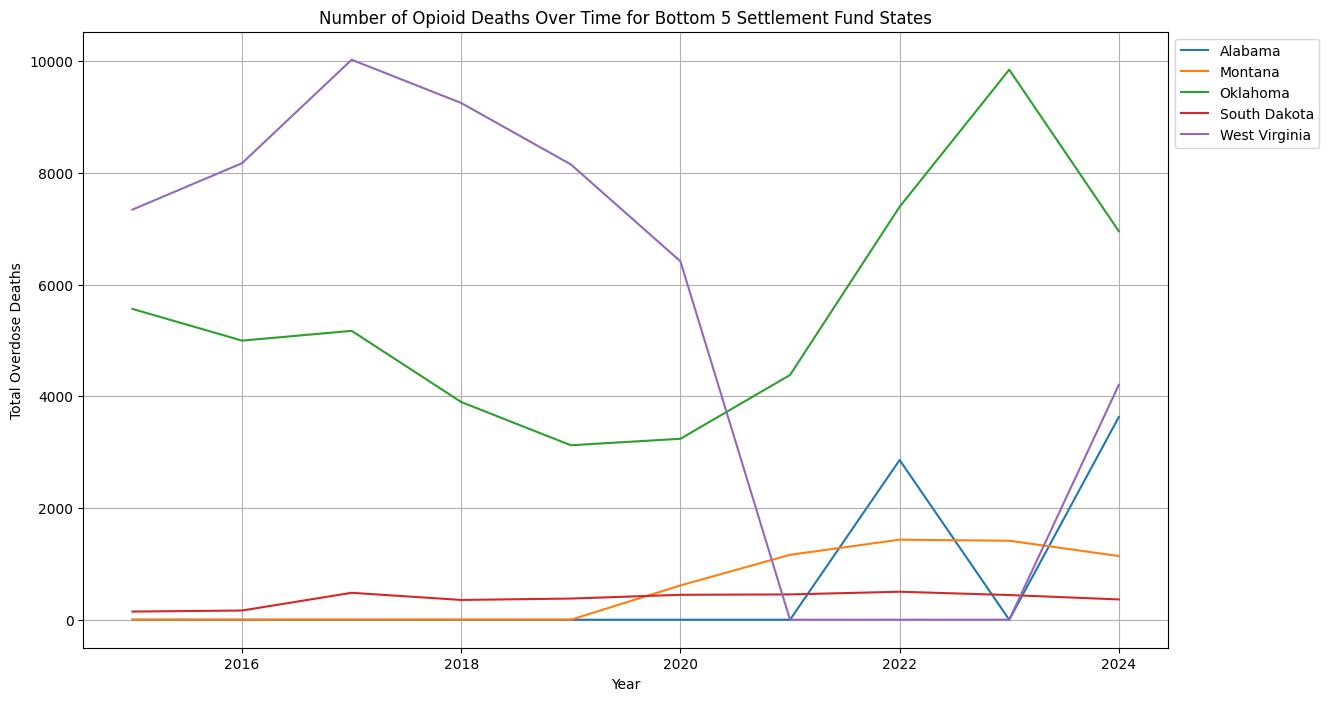

In [33]:
# Sort the DataFrame by '2022 Settlement Payout'
sorted_df = merged_df.sort_values(by='2022 Settlement Payout', ascending=False)

# Get the top 5 and bottom 5 states by settlement payout
top_5_states = sorted_df['State Name'].unique()[:5]
bottom_5_states = sorted_df['State Name'].unique()[-5:]

# Separate DataFrames for Top 5 and Bottom 5 states
top_5_df = merged_df[merged_df['State Name'].isin(top_5_states)]
bottom_5_df = merged_df[merged_df['State Name'].isin(bottom_5_states)]
# Filter the DataFrame to only include the top 5 and bottom 5 states
filtered_df = merged_df[merged_df['State Name'].isin(top_5_states) | merged_df['State Name'].isin(bottom_5_states)]

# Plotting Top 5 States
plt.figure(figsize=(14, 8))
for state in top_5_df['State Name'].unique():
    state_data = top_5_df[top_5_df['State Name'] == state]
    plt.plot(state_data['Year'], state_data['Total Overdose Deaths'], label=state)

plt.title('Number of Opioid Deaths Over Time for Top 5 Settlement Fund States')
plt.xlabel('Year')
plt.ylabel('Total Overdose Deaths')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# Plotting Bottom 5 States
plt.figure(figsize=(14, 8))
for state in bottom_5_df['State Name'].unique():
    state_data = bottom_5_df[bottom_5_df['State Name'] == state]
    plt.plot(state_data['Year'], state_data['Total Overdose Deaths'], label=state)

plt.title('Number of Opioid Deaths Over Time for Bottom 5 Settlement Fund States')
plt.xlabel('Year')
plt.ylabel('Total Overdose Deaths')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [ ]:
rom transformers import BertTokenizer, BertForSequenceClassification

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize_function(example):
    return tokenizer(example['text'], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].shuffle(seed=42).select(range(2000)),
    eval_dataset=tokenized_dataset["test"].select(range(500))
)

trainer.train()

eval_result = trainer.evaluate()
print(eval_result)

text = "The movie was fantastic!"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
predicted_class = outputs.logits.argmax().item()
print(f"Predicted class: {predicted_class}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Daiki Sai\miniconda3\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Daiki Sai\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

C:\Users\Daiki Sai\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Daiki Sai\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


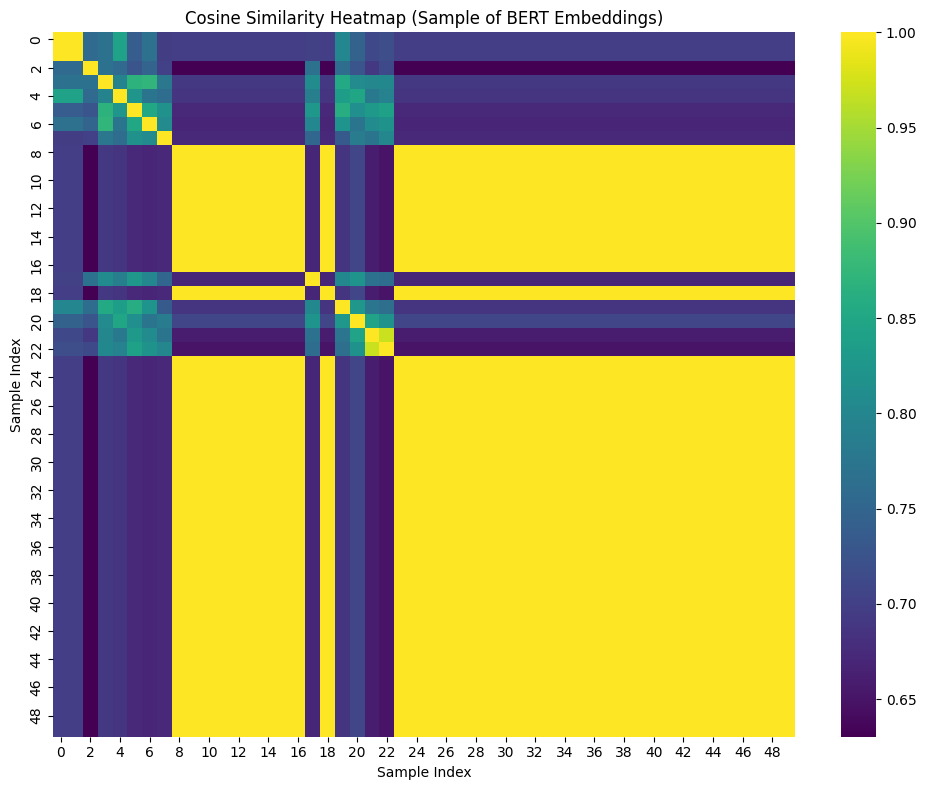

In [35]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\Daiki Sai\Downloads\FacebookNaloxoneData.csv")  # Adjust path if needed
df = df.dropna(subset=['snapshot/body/text'])
texts = df['snapshot/body/text'].astype(str).tolist()

device = torch.device("cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

batch_size = 16
all_embeddings = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    encoded = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        output = model(**encoded)
        cls_embeddings = output.last_hidden_state[:, 0, :]  # [CLS] token
        all_embeddings.append(cls_embeddings.cpu().numpy())

embeddings = np.vstack(all_embeddings)

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

similarity_matrix = 1 - pairwise_distances(embeddings, metric='cosine')

result_df = pd.DataFrame({
    'Text': texts,
    'Cluster': cluster_labels
})

sample_idx = 50
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:sample_idx, :sample_idx], cmap='viridis')
plt.title("Cosine Similarity Heatmap (Sample of BERT Embeddings)")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

result_df.to_csv("bert_clustered_texts.csv", index=False)


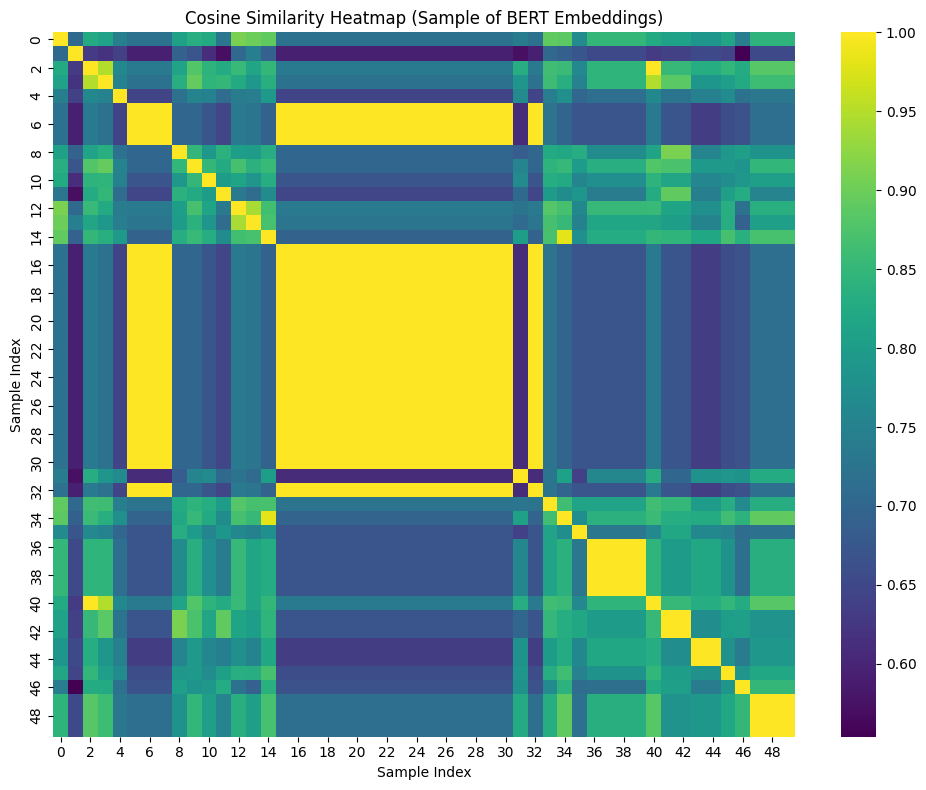

,Text,Cluster,Cluster Name
0,Just Added 😎\nLOT OF 20 **HARD TRANCE** DJ VIN...,2,"opium pillow, chronic pain, pain study"
1,1960s Chinese ceramic Female Porcelain Opium P...,2,"opium pillow, chronic pain, pain study"
2,"At @integrativemedicalwellness, we combine the...",0,"point massage, massagetherapy painmanagement, ..."
3,"At Integrative Medical Wellness, we specialize...",0,"point massage, massagetherapy painmanagement, ..."
4,Hello All!\nWelcome to Slide Society Drift Day...,0,"point massage, massagetherapy painmanagement, ..."


In [40]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from keybert import KeyBERT


# Use engine='python' to handle complex formatting
df_narcotic = pd.read_csv(r"C:\Users\Daiki Sai\Downloads\FacebookNarcoticData.csv", engine='python')
df_fentanyl = pd.read_csv(r"C:\Users\Daiki Sai\Downloads\FacebookFentanylData.csv", engine='python')
df_opioid = pd.read_csv(r"C:\Users\Daiki Sai\Downloads\FacebookOpioidData.csv", engine='python')
df_naloxone = pd.read_csv(r"C:\Users\Daiki Sai\Downloads\FacebookNaloxoneData.csv", engine='python')

# Combine all dataframes
df = pd.concat([df_narcotic, df_fentanyl, df_opioid, df_naloxone], ignore_index=True)
df = df.dropna(subset=['snapshot/body/text'])
texts = df['snapshot/body/text'].astype(str).tolist()


device = torch.device("cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

batch_size = 20
all_embeddings = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    encoded = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt').to(device)

    with torch.no_grad():
        output = model(**encoded)
        cls_embeddings = output.last_hidden_state[:, 0, :]  # CLS token
        all_embeddings.append(cls_embeddings.cpu().numpy())

embeddings = np.vstack(all_embeddings)

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

result_df = pd.DataFrame({
    'Text': texts,
    'Cluster': cluster_labels
})


kw_model = KeyBERT(model='all-MiniLM-L6-v2')  # lighter and great for short docs
cluster_names = {}

for cluster_num in range(num_clusters):
    cluster_texts = result_df[result_df['Cluster'] == cluster_num]['Text'].tolist()
    joined_text = " ".join(cluster_texts[:50])  # use top 50 examples
    keywords = kw_model.extract_keywords(joined_text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=3)
    cluster_names[cluster_num] = ", ".join([kw[0] for kw in keywords])

result_df['Cluster Name'] = result_df['Cluster'].map(cluster_names)

similarity_matrix = 1 - pairwise_distances(embeddings, metric='cosine')

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:50, :50], cmap='viridis')  # sample for clarity
plt.title("Cosine Similarity Heatmap (Sample of BERT Embeddings)")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()

result_df.to_csv("bert_clustered_with_auto_labels.csv", index=False)

# Preview final result
result_df.head()


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load dataset
df = pd.read_csv("FacebookNarcoticData.csv")

# Extract ad descriptions
ad_texts = df['snapshot/body/text'].dropna().reset_index(drop=True)

# Vectorize ad descriptions
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(ad_texts)

# Apply LDA
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(X)

# Assign dominant topic
topic_assignments = lda.transform(X).argmax(axis=1)

# Map LDA topics to your categories
topic_to_category = {
    0: 'Prevention and Harm Reduction (Awareness)',
    1: 'Products (opioid-containing products)',
    2: 'Research, Data, and Administrative Support',
    3: 'Treatment and Recovery Services'
}

# Create categorized ads DataFrame
categorized_ads = pd.DataFrame({
    'ad_text': ad_texts,
    'topic': topic_assignments
})
categorized_ads['category'] = categorized_ads['topic'].map(topic_to_category)

# Optional: Save to CSV
categorized_ads.to_csv("categorized_ads.csv", index=False)

# Display sample categorized ads
print(categorized_ads.head(10))


                                             ad_text  topic  \
0  Just Added 😎\nLOT OF 20 **HARD TRANCE** DJ VIN...      1   
1  1960s Chinese ceramic Female Porcelain Opium P...      1   
2  At @integrativemedicalwellness, we combine the...      3   
3  At Integrative Medical Wellness, we specialize...      3   
4  Hello All!\nWelcome to Slide Society Drift Day...      2   
5                                  {{product.brand}}      1   
6                                  {{product.brand}}      1   
7                                  {{product.brand}}      1   
8  YOUR NON-NARCOTIC PAIN SOLUTION. See how the R...      3   
9  🧠💡 What if your pain isn’t just physical?\n\nT...      3   

                                     category  
0       Products (opioid-containing products)  
1       Products (opioid-containing products)  
2             Treatment and Recovery Services  
3             Treatment and Recovery Services  
4  Research, Data, and Administrative Support  
5       Products (

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# List of absolute file paths (change file names as needed)
files = [
    r"C:\Users\Daiki Sai\Downloads\FacebookNarcoticData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookNaloxoneData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookFentanylData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookOpioidData.csv",
    r"C:\Users\Daiki Sai\Downloads\Heroin-154.csv",
    r"C:\Users\Daiki Sai\Downloads\Morphine-1097.csv",
    r"C:\Users\Daiki Sai\Downloads\Codeine-131.csv",
    r"C:\Users\Daiki Sai\Downloads\Oxycodone-312.csv",
    r"C:\Users\Daiki Sai\Downloads\Methadone-47.csv",
    r"C:\Users\Daiki Sai\Downloads\SubstanceUseDisorder - 2031.csv",
    r"C:\Users\Daiki Sai\Downloads\PDMP-87.csv",
    r"C:\Users\Daiki Sai\Downloads\Naloxone-87.csv",
    r"C:\Users\Daiki Sai\Downloads\Methamphetamine-992.csv",
    r"C:\Users\Daiki Sai\Downloads\Opium1685-123.csv",
    r"C:\Users\Daiki Sai\Downloads\Opioid-247-123.csv",
    r"C:\Users\Daiki Sai\Downloads\MOUD-175-122.csv",
    r"C:\Users\Daiki Sai\Downloads\Benzodiazepines-137-123.csv"
]

# Load and combine ad descriptions and page names
dfs = [pd.read_csv(file) for file in files]
all_ads = pd.concat([df[['snapshot/body/text', 'snapshot/page_name']] for df in dfs], ignore_index=True)
all_ads = all_ads.dropna(subset=['snapshot/body/text']).reset_index(drop=True)

# Vectorize ad descriptions (remove English stop words)
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(all_ads['snapshot/body/text'])

# Apply LDA with 4 topics
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(X)

# Assign dominant topic
topic_assignments = lda.transform(X).argmax(axis=1)

# Map topics to categories
topic_to_category = {
    0: 'Prevention and Harm Reduction (Awareness)',
    1: 'Products (opioid-containing products)',
    2: 'Research, Data, and Administrative Support',
    3: 'Treatment and Recovery Services'
}

# Assign initial categories based on LDA
all_ads['topic'] = topic_assignments
all_ads['category'] = all_ads['topic'].map(topic_to_category)

# Override category for ads containing "product.brand"
all_ads.loc[all_ads['snapshot/body/text'].str.contains('product.brand', case=False), 'category'] = 'Products (opioid-containing products)'

# Save to CSV
all_ads.to_csv(r"C:\Users\Daiki Sai\Downloads\categorized_all_ads_final.csv", index=False)

# Display sample
print(all_ads.head(10))


C:\Users\Daiki Sai\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: DtypeWarning: Columns (7,11,12,13,15,16,17,18,19,20,21,32,33,34,38,39,47,54,59,66,68,69,70,71,72,73,74,75,76,77,78,79,83,84,85,86,87,88,89,90,91,92,93,94,98,99,100,101,102,103,104,105,106,107,108,109,113,114,115,116,117,118,119,120,121,122,123,124,128,129,130,131,132,133,134,135,136,137,138,139,143,144,145,146,147,148,149,150,151,152,153,154,158,159,160,161,162,163,164,165,166,167,168,169,173,174,175,176,177,178,179,180,181,182,183,184,188,189,190,191,192,193,194,195,196,197,198,199,203,204,205,206,207,208,209,210,211,212,213,214,218,220,221,223,224,225,226,233,235,236,238,239,240,241,248,250,251,253,254,255,256,263,265,266,268,269,270,271,278,280,281,283,284,285,286,293,295,296,298,299,300,301,308,310,311,313,314,315,316,323,325,326,328,329,330,331,338,340,341,343,344,345,346,353,355,356,358,359,360,361,368,370,371,373,374,375,376,383,385,386,388,389,390,391,398,400,401,403,404,405,406,413,415,416,4

                                  snapshot/body/text  \
0  Just Added 😎\nLOT OF 20 **HARD TRANCE** DJ VIN...   
1  1960s Chinese ceramic Female Porcelain Opium P...   
2  At @integrativemedicalwellness, we combine the...   
3  At Integrative Medical Wellness, we specialize...   
4  Hello All!\nWelcome to Slide Society Drift Day...   
5                                  {{product.brand}}   
6                                  {{product.brand}}   
7                                  {{product.brand}}   
8  YOUR NON-NARCOTIC PAIN SOLUTION. See how the R...   
9  🧠💡 What if your pain isn’t just physical?\n\nT...   

                snapshot/page_name  topic  \
0                      Vinyl4Cheap      3   
1                   objectfixation      3   
2  Integrative Medical Wellness MD      3   
3  Integrative Medical Wellness MD      3   
4           Slide Society Drifting      3   
5                   Hyperblade USA      1   
6                   Hyperblade USA      1   
7                   Hyp

In [7]:
print(len(all_ads))

8719


In [11]:
import pandas as pd
import re
import spacy
from geopy.geocoders import Nominatim
from statsmodels.formula.api import ols

# ===== 1. Setup NLP and Geolocation =====
nlp = spacy.load("en_core_web_sm")
geolocator = Nominatim(user_agent="geoapiExercises")

state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# ===== 2. Process Facebook Ads CSVs =====
def process_ads_csv(csv_files):
    ads_data = []
    for file in csv_files:
        df = pd.read_csv(file)
        for _, row in df.iterrows():
            try:
                text = row['snapshot/body/text']
                year = pd.to_datetime(row['end_date']).year
                doc = nlp(text)
                locations = [ent.text for ent in doc.ents if ent.label_ == "GPE"]
                for loc in locations:
                    geo = geolocator.geocode(f"{loc}, United States", addressdetails=True)
                    if geo and geo.raw['address'].get('state'):
                        state_full = geo.raw['address']['state']
                        if state_full in state_abbrev:
                            ads_data.append({'STATE': state_abbrev[state_full], 'YEAR': year})
            except:
                continue
    return pd.DataFrame(ads_data)

# ===== 3. Aggregate Ad Exposure =====
csv_files = [
    r"C:\Users\Daiki Sai\Downloads\FacebookNarcoticData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookNaloxoneData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookFentanylData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookOpioidData.csv",
    r"C:\Users\Daiki Sai\Downloads\Heroin-154.csv",
    r"C:\Users\Daiki Sai\Downloads\Morphine-1097.csv",
    r"C:\Users\Daiki Sai\Downloads\Codeine-131.csv",
    r"C:\Users\Daiki Sai\Downloads\Oxycodone-312.csv",
    r"C:\Users\Daiki Sai\Downloads\Methadone-47.csv",
    r"C:\Users\Daiki Sai\Downloads\SubstanceUseDisorder - 2031.csv",
    r"C:\Users\Daiki Sai\Downloads\PDMP-87.csv",
    r"C:\Users\Daiki Sai\Downloads\Naloxone-87.csv",
    r"C:\Users\Daiki Sai\Downloads\Methamphetamine-992.csv",
    r"C:\Users\Daiki Sai\Downloads\Opium1685-123.csv",
    r"C:\Users\Daiki Sai\Downloads\Opioid-247-123.csv",
    r"C:\Users\Daiki Sai\Downloads\MOUD-175-122.csv",
    r"C:\Users\Daiki Sai\Downloads\Benzodiazepines-137-123.csv"
]
ads_df = process_ads_csv(csv_files)
ad_exposure = ads_df.groupby(['STATE', 'YEAR']).size().reset_index(name='ad_count')

# ===== 4. Load Death and Payout Data =====
death_data = pd.read_csv(r"C:\Users\Daiki Sai\Downloads\death_data.csv")  # Columns: STATE, YEAR, DEATHS, RATE
payouts_data = pd.read_excel(r"C:\Users\Daiki Sai\Downloads\payouts_data.xlsx", sheet_name='State-level')

# Reshape payouts
payouts_long = pd.melt(payouts_data, id_vars=['name'], 
                       value_vars=[col for col in payouts_data.columns if 'payout' in col.lower() and 'future' not in col.lower()], 
                       var_name='YEAR', value_name='PAYOUT')
payouts_long['YEAR'] = payouts_long['YEAR'].str.extract(r'(\d{4})').dropna().astype(int)
payouts_long['STATE'] = payouts_long['name'].map(state_abbrev)

# ===== 5. Merge All Data =====
merged_df = death_data.merge(payouts_long[['STATE', 'YEAR', 'PAYOUT']], on=['STATE', 'YEAR'], how='left')
merged_df = merged_df.merge(ad_exposure, on=['STATE', 'YEAR'], how='left')
merged_df['ad_count'] = merged_df['ad_count'].fillna(0)

# ===== 6. Difference-in-Differences Setup =====
merged_df['POST'] = (merged_df['YEAR'] >= 2022).astype(int)
median_payout_2022 = merged_df[merged_df['YEAR'] == 2022]['PAYOUT'].median()
merged_df['TREATED'] = (merged_df['PAYOUT'] >= median_payout_2022).astype(int)
merged_df['TREATED_POST'] = merged_df['TREATED'] * merged_df['POST']
merged_df['TREATED_POST_ADS'] = merged_df['TREATED_POST'] * merged_df['ad_count']

# ===== 7. Run DiD Regression =====
model = ols('DEATHS ~ TREATED + POST + TREATED_POST + ad_count + TREATED_POST_ADS', data=merged_df.dropna(subset=['PAYOUT'])).fit()
print(model.summary())


KeyError: 'STATE'

In [12]:
print(ads_df.head())
print(ads_df.columns)

Empty DataFrame
Columns: []
Index: []
Index([], dtype='object')


In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.formula.api import ols

# ===== 1. Load and Combine Facebook Ads CSVs =====
files = [
    r"C:\Users\Daiki Sai\Downloads\FacebookNarcoticData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookNaloxoneData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookFentanylData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookOpioidData.csv",
    r"C:\Users\Daiki Sai\Downloads\Heroin-154.csv",
    r"C:\Users\Daiki Sai\Downloads\Morphine-1097.csv",
    r"C:\Users\Daiki Sai\Downloads\Codeine-131.csv",
    r"C:\Users\Daiki Sai\Downloads\Oxycodone-312.csv",
    r"C:\Users\Daiki Sai\Downloads\Methadone-47.csv",
    r"C:\Users\Daiki Sai\Downloads\SubstanceUseDisorder - 2031.csv",
    r"C:\Users\Daiki Sai\Downloads\PDMP-87.csv",
    r"C:\Users\Daiki Sai\Downloads\Naloxone-87.csv",
    r"C:\Users\Daiki Sai\Downloads\Methamphetamine-992.csv",
    r"C:\Users\Daiki Sai\Downloads\Opium1685-123.csv",
    r"C:\Users\Daiki Sai\Downloads\Opioid-247-123.csv",
    r"C:\Users\Daiki Sai\Downloads\MOUD-175-122.csv",
    r"C:\Users\Daiki Sai\Downloads\Benzodiazepines-137-123.csv"
]

dfs = [pd.read_csv(file) for file in files]
all_ads = pd.concat([df[['snapshot/body/text', 'snapshot/page_name', 'end_date']] for df in dfs], ignore_index=True)
all_ads = all_ads.dropna(subset=['snapshot/body/text', 'end_date']).reset_index(drop=True)

# ===== 2. Extract Year =====
all_ads['YEAR'] = pd.to_datetime(all_ads['end_date']).dt.year

# ===== 3. Apply LDA Categorization =====
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(all_ads['snapshot/body/text'])
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(X)

topic_assignments = lda.transform(X).argmax(axis=1)
topic_to_category = {
    0: 'Prevention and Harm Reduction (Awareness)',
    1: 'Products (opioid-containing products)',
    2: 'Research, Data, and Administrative Support',
    3: 'Treatment and Recovery Services'
}
all_ads['topic'] = topic_assignments
all_ads['category'] = all_ads['topic'].map(topic_to_category)

# Override category for 'product.brand'
all_ads.loc[all_ads['snapshot/body/text'].str.contains('product.brand', case=False), 'category'] = 'Products (opioid-containing products)'

# ===== 4. Aggregate Ad Counts =====
ad_counts = all_ads.groupby(['category', 'YEAR']).size().reset_index(name='ad_count')

# ===== 5. Load Death and Payout Data =====
death_data = pd.read_csv(r"C:\Users\Daiki Sai\Downloads\data-table (2).csv")  # Opioid deaths
payouts_data = pd.read_excel(r"C:\Users\Daiki Sai\Downloads\Opioid-Settlement-Payouts-Data_040124.xlsx", sheet_name='State-level')

state_abbrev = {'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
                'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
                'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
                'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
                'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
                'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
                'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
                'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
                'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
                'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}

payouts_long = pd.melt(payouts_data, id_vars=['name'], 
                       value_vars=[col for col in payouts_data.columns if 'payout' in col.lower() and 'future' not in col.lower()], 
                       var_name='YEAR', value_name='PAYOUT')
payouts_long['YEAR'] = payouts_long['YEAR'].str.extract(r'(\d{4})').dropna().astype(int)
payouts_long['STATE'] = payouts_long['name'].map(state_abbrev)

# ===== 6. DiD Analysis for Categories =====
# Setup DiD: Treated = Treatment ads, Control = Products ads
ad_counts['POST'] = (ad_counts['YEAR'] >= 2022).astype(int)
ad_counts['TREATED'] = ad_counts['category'].apply(lambda x: 1 if x == 'Treatment and Recovery Services' else 0)
ad_counts['TREATED_POST'] = ad_counts['TREATED'] * ad_counts['POST']

# Run DiD regression
model = ols('ad_count ~ TREATED + POST + TREATED_POST', data=ad_counts).fit()
print(model.summary())


C:\Users\Daiki Sai\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: DtypeWarning: Columns (7,11,12,13,15,16,17,18,19,20,21,32,33,34,38,39,47,54,59,66,68,69,70,71,72,73,74,75,76,77,78,79,83,84,85,86,87,88,89,90,91,92,93,94,98,99,100,101,102,103,104,105,106,107,108,109,113,114,115,116,117,118,119,120,121,122,123,124,128,129,130,131,132,133,134,135,136,137,138,139,143,144,145,146,147,148,149,150,151,152,153,154,158,159,160,161,162,163,164,165,166,167,168,169,173,174,175,176,177,178,179,180,181,182,183,184,188,189,190,191,192,193,194,195,196,197,198,199,203,204,205,206,207,208,209,210,211,212,213,214,218,220,221,223,224,225,226,233,235,236,238,239,240,241,248,250,251,253,254,255,256,263,265,266,268,269,270,271,278,280,281,283,284,285,286,293,295,296,298,299,300,301,308,310,311,313,314,315,316,323,325,326,328,329,330,331,338,340,341,343,344,345,346,353,355,356,358,359,360,361,368,370,371,373,374,375,376,383,385,386,388,389,390,391,398,400,401,403,404,405,406,413,415,416,4

                            OLS Regression Results                            
Dep. Variable:               ad_count   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     44.56
Date:                Mon, 28 Apr 2025   Prob (F-statistic):             0.0217
Time:                        08:22:13   Log-Likelihood:                -30.292
No. Observations:                   4   AIC:                             64.58
Df Residuals:                       2   BIC:                             63.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      897.0000    384.243      2.334   

C:\Users\Daiki Sai\miniconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\Daiki Sai\miniconda3\lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


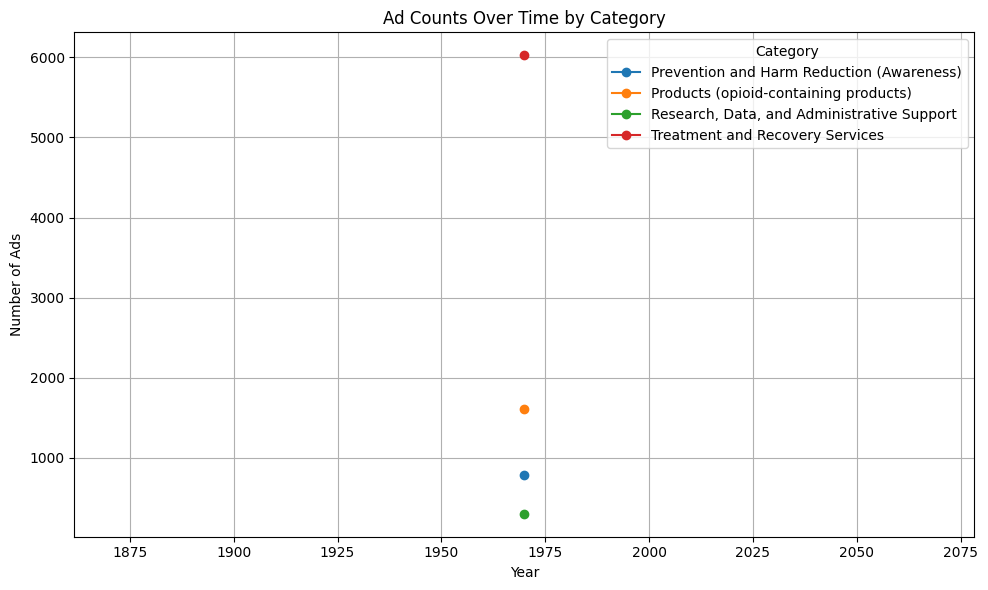

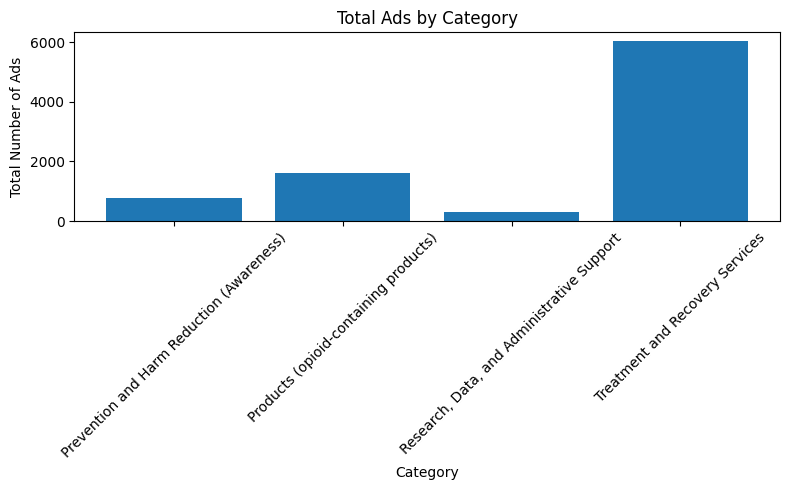

In [20]:
import matplotlib.pyplot as plt

# ===== Aggregate ad counts by category and year =====
ad_trends = all_ads.groupby(['category', 'YEAR']).size().reset_index(name='ad_count')

# ===== Plot =====
plt.figure(figsize=(10,6))
for category in ad_trends['category'].unique():
    subset = ad_trends[ad_trends['category'] == category]
    plt.plot(subset['YEAR'], subset['ad_count'], marker='o', label=category)

plt.title('Ad Counts Over Time by Category')
plt.xlabel('Year')
plt.ylabel('Number of Ads')
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== Aggregate total ad counts by category =====
total_ads = all_ads.groupby('category').size().reset_index(name='total_count')

# ===== Plot =====
plt.figure(figsize=(8,5))
plt.bar(total_ads['category'], total_ads['total_count'])
plt.title('Total Ads by Category')
plt.xlabel('Category')
plt.ylabel('Total Number of Ads')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
# Check YEAR distribution
print(all_ads['YEAR'].describe())
print(all_ads['YEAR'].unique())

count    8718.0
mean     1970.0
std         0.0
min      1970.0
25%      1970.0
50%      1970.0
75%      1970.0
max      1970.0
Name: YEAR, dtype: float64
[1970]


In [22]:
# Inspect the raw 'end_date' format
print(all_ads['end_date'].head(10))


0    1.744009e+09
1    1.744009e+09
2    1.744009e+09
3    1.744009e+09
4    1.744009e+09
5    1.744009e+09
6    1.744009e+09
7    1.744009e+09
8    1.743836e+09
9    1.744009e+09
Name: end_date, dtype: float64


In [25]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

# ===== 1. Load and Combine Facebook Ads CSVs =====
files = [
    r"C:\Users\Daiki Sai\Downloads\FacebookNarcoticData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookNaloxoneData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookFentanylData.csv",
    r"C:\Users\Daiki Sai\Downloads\FacebookOpioidData.csv",
    r"C:\Users\Daiki Sai\Downloads\Heroin-154.csv",
    r"C:\Users\Daiki Sai\Downloads\Morphine-1097.csv",
    r"C:\Users\Daiki Sai\Downloads\Codeine-131.csv",
    r"C:\Users\Daiki Sai\Downloads\Oxycodone-312.csv",
    r"C:\Users\Daiki Sai\Downloads\Methadone-47.csv",
    r"C:\Users\Daiki Sai\Downloads\SubstanceUseDisorder - 2031.csv",
    r"C:\Users\Daiki Sai\Downloads\PDMP-87.csv",
    r"C:\Users\Daiki Sai\Downloads\Naloxone-87.csv",
    r"C:\Users\Daiki Sai\Downloads\Methamphetamine-992.csv",
    r"C:\Users\Daiki Sai\Downloads\Opium1685-123.csv",
    r"C:\Users\Daiki Sai\Downloads\Opioid-247-123.csv",
    r"C:\Users\Daiki Sai\Downloads\MOUD-175-122.csv",
    r"C:\Users\Daiki Sai\Downloads\Benzodiazepines-137-123.csv"
]

dfs = [pd.read_csv(file) for file in files]
all_ads = pd.concat([df[['snapshot/body/text', 'snapshot/page_name', 'end_date']] for df in dfs], ignore_index=True)
all_ads = all_ads.dropna(subset=['snapshot/body/text', 'end_date']).reset_index(drop=True)

# ===== 2. Extract YEAR from Unix timestamp =====
all_ads['YEAR'] = pd.to_datetime(all_ads['end_date'], unit='s', errors='coerce').dt.year

# ===== 3. Apply LDA Categorization =====
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(all_ads['snapshot/body/text'])
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(X)

topic_assignments = lda.transform(X).argmax(axis=1)
topic_to_category = {
    0: 'Prevention and Harm Reduction (Awareness)',
    1: 'Products (opioid-containing products)',
    2: 'Research, Data, and Administrative Support',
    3: 'Treatment and Recovery Services'
}
all_ads['topic'] = topic_assignments
all_ads['category'] = all_ads['topic'].map(topic_to_category)

# Override category for 'product.brand'
all_ads.loc[all_ads['snapshot/body/text'].str.contains('product.brand', case=False), 'category'] = 'Products (opioid-containing products)'

# ===== 4. Aggregate Ad Counts by Category and Year =====
ad_counts = all_ads.groupby(['category', 'YEAR']).size().reset_index(name='ad_count')

# ===== 5. Category-Based DiD =====
ad_counts['POST'] = (ad_counts['YEAR'] >= 2022).astype(int)
ad_counts['TREATED'] = ad_counts['category'].apply(lambda x: 1 if x == 'Treatment and Recovery Services' else 0)
ad_counts['TREATED_POST'] = ad_counts['TREATED'] * ad_counts['POST']

# Run DiD regression
model = ols('ad_count ~ TREATED + POST + TREATED_POST', data=ad_counts).fit()
print(model.summary())



C:\Users\Daiki Sai\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: DtypeWarning: Columns (7,11,12,13,15,16,17,18,19,20,21,32,33,34,38,39,47,54,59,66,68,69,70,71,72,73,74,75,76,77,78,79,83,84,85,86,87,88,89,90,91,92,93,94,98,99,100,101,102,103,104,105,106,107,108,109,113,114,115,116,117,118,119,120,121,122,123,124,128,129,130,131,132,133,134,135,136,137,138,139,143,144,145,146,147,148,149,150,151,152,153,154,158,159,160,161,162,163,164,165,166,167,168,169,173,174,175,176,177,178,179,180,181,182,183,184,188,189,190,191,192,193,194,195,196,197,198,199,203,204,205,206,207,208,209,210,211,212,213,214,218,220,221,223,224,225,226,233,235,236,238,239,240,241,248,250,251,253,254,255,256,263,265,266,268,269,270,271,278,280,281,283,284,285,286,293,295,296,298,299,300,301,308,310,311,313,314,315,316,323,325,326,328,329,330,331,338,340,341,343,344,345,346,353,355,356,358,359,360,361,368,370,371,373,374,375,376,383,385,386,388,389,390,391,398,400,401,403,404,405,406,413,415,416,4

                            OLS Regression Results                            
Dep. Variable:               ad_count   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     9.258
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           0.000204
Time:                        08:28:13   Log-Likelihood:                -230.46
No. Observations:                  32   AIC:                             468.9
Df Residuals:                      28   BIC:                             474.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.5000    100.215      0.105   

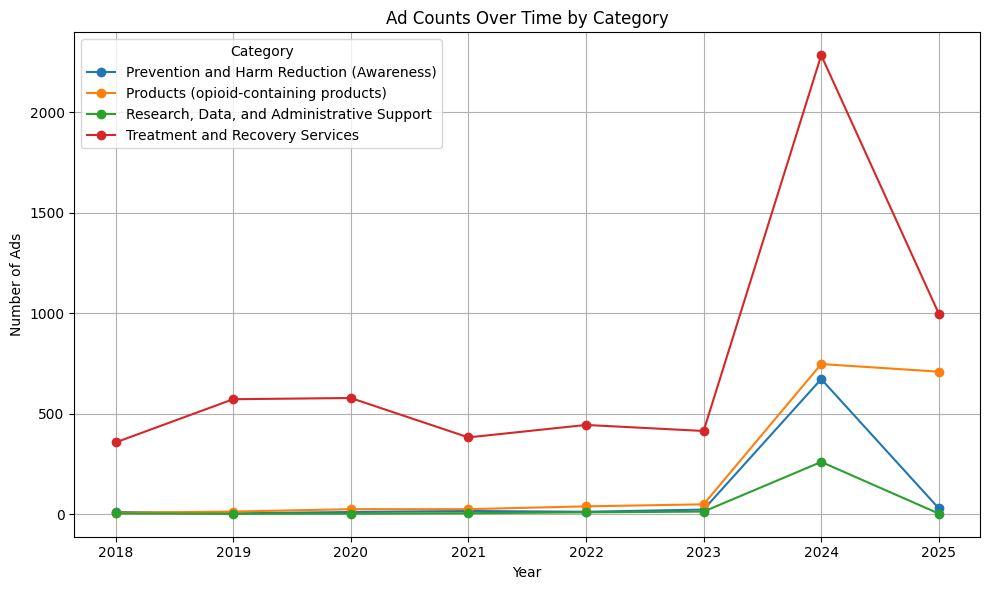

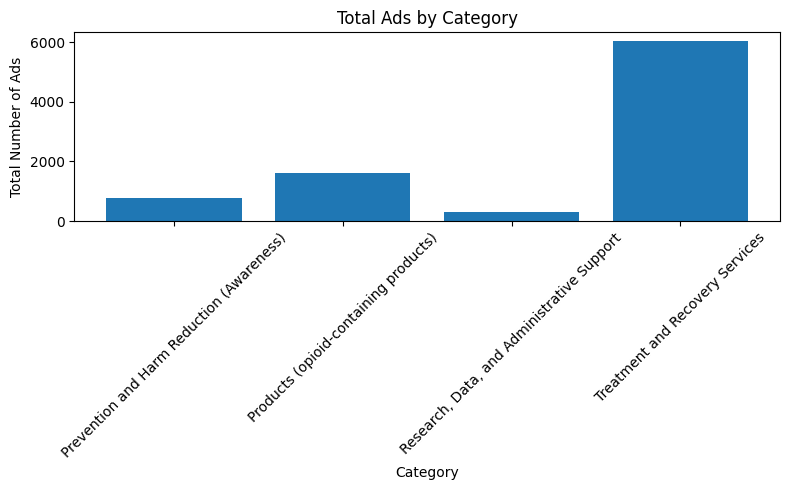

In [24]:
# ===== 6. Plot: Ad Counts Over Time by Category =====
plt.figure(figsize=(10,6))
for category in ad_counts['category'].unique():
    subset = ad_counts[ad_counts['category'] == category]
    plt.plot(subset['YEAR'], subset['ad_count'], marker='o', label=category)

plt.title('Ad Counts Over Time by Category')
plt.xlabel('Year')
plt.ylabel('Number of Ads')
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()

# ===== 7. Plot: Total Ads by Category =====
total_ads = all_ads.groupby('category').size().reset_index(name='total_count')

plt.figure(figsize=(8,5))
plt.bar(total_ads['category'], total_ads['total_count'])
plt.title('Total Ads by Category')
plt.xlabel('Category')
plt.ylabel('Total Number of Ads')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\conda_tmp\ipykernel_2172\4293205520.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=ad_trends, x='YEAR', y='ad_count', hue='category', ci=95, marker='o')


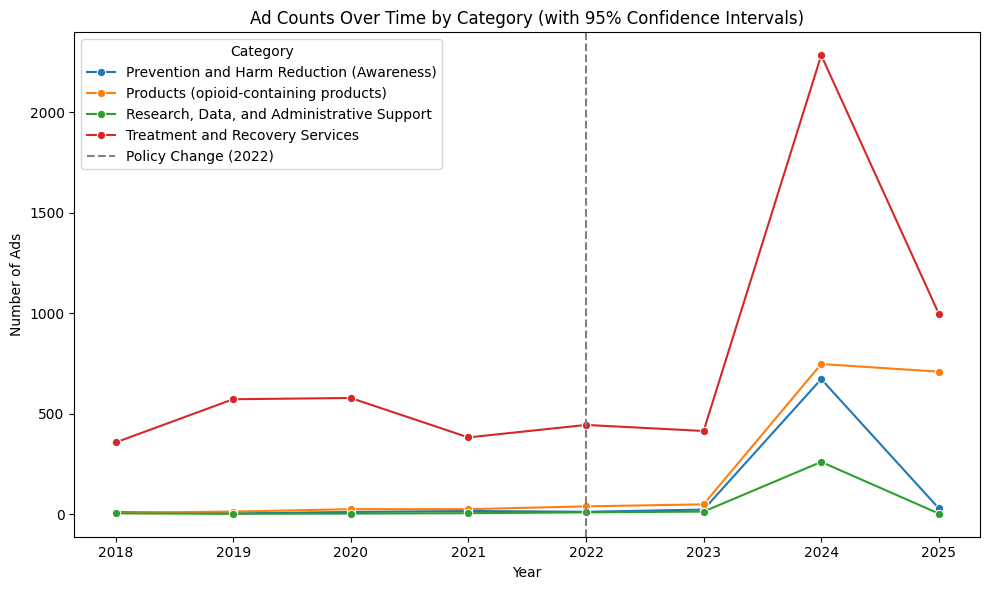

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# ===== Prepare pre/post data =====
ad_trends = all_ads.groupby(['category', 'YEAR']).size().reset_index(name='ad_count')
ad_trends['POST'] = (ad_trends['YEAR'] >= 2022).astype(int)

# ===== Plot with Seaborn =====
plt.figure(figsize=(10,6))
sns.lineplot(data=ad_trends, x='YEAR', y='ad_count', hue='category', ci=95, marker='o')

# ===== Highlight the policy change (2022) =====
plt.axvline(x=2022, color='gray', linestyle='--', label='Policy Change (2022)')
plt.title('Ad Counts Over Time by Category (with 95% Confidence Intervals)')
plt.xlabel('Year')
plt.ylabel('Number of Ads')
plt.legend(title='Category')
plt.tight_layout()
plt.show()


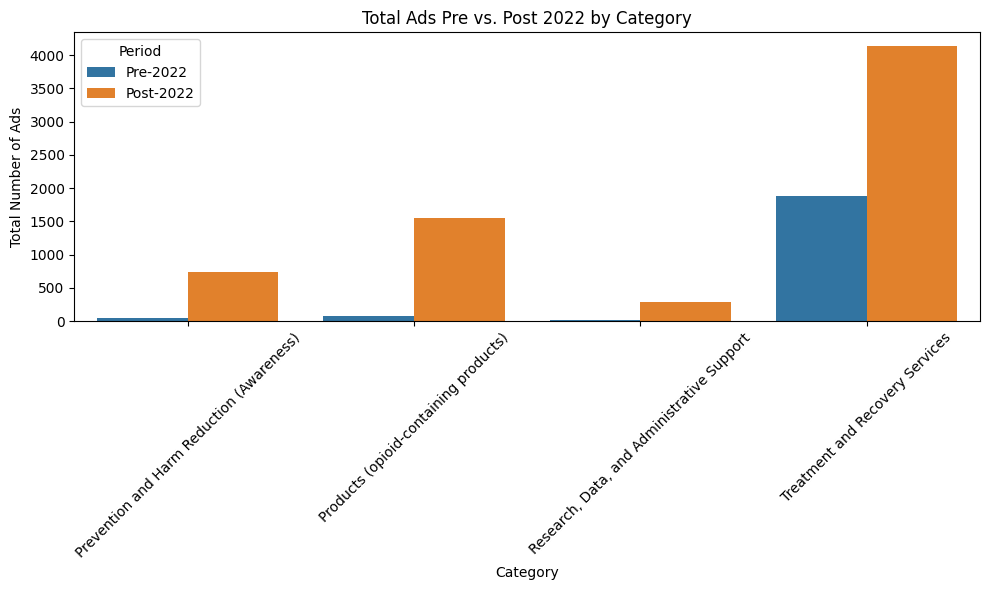

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# ===== Prepare pre/post aggregation =====
prepost_counts = all_ads.copy()
prepost_counts['POST'] = (prepost_counts['YEAR'] >= 2022).astype(int)
prepost_summary = prepost_counts.groupby(['category', 'POST']).size().reset_index(name='ad_count')
prepost_summary['Period'] = prepost_summary['POST'].map({0: 'Pre-2022', 1: 'Post-2022'})

# ===== Plot =====
plt.figure(figsize=(10,6))
sns.barplot(data=prepost_summary, x='category', y='ad_count', hue='Period')
plt.title('Total Ads Pre vs. Post 2022 by Category')
plt.xlabel('Category')
plt.ylabel('Total Number of Ads')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


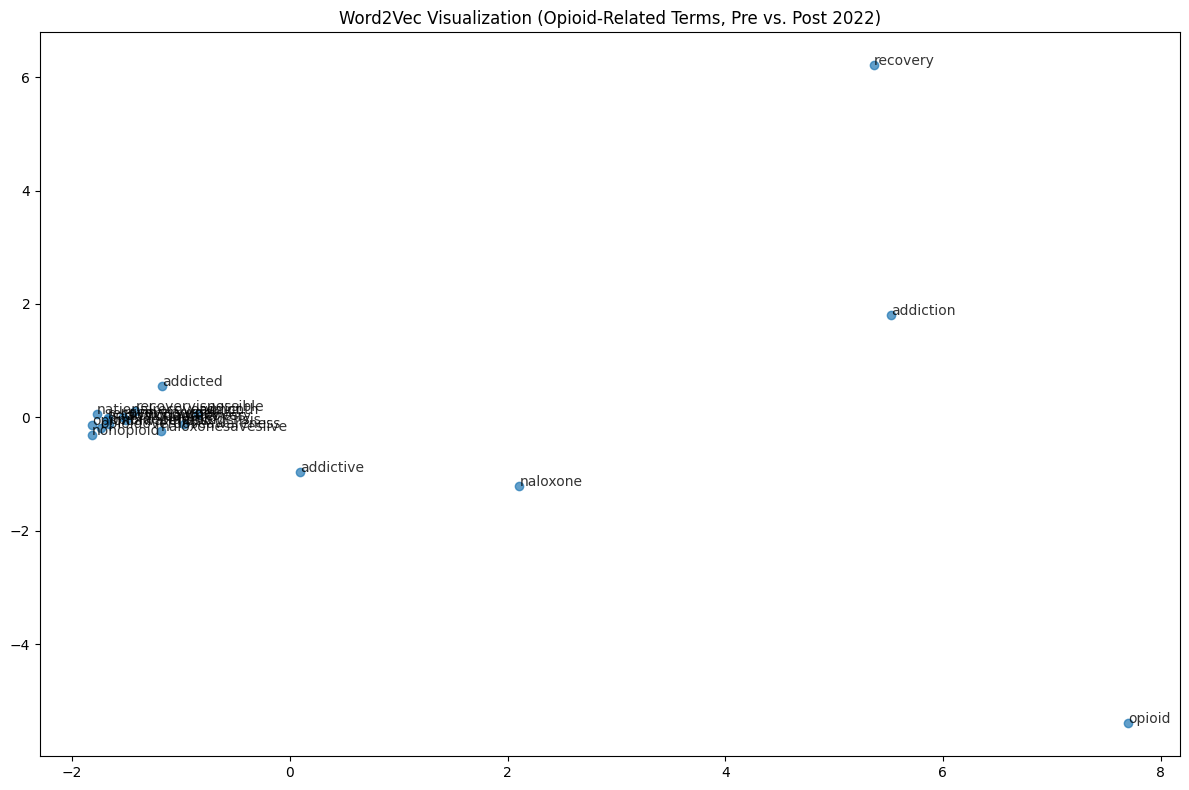

In [33]:
import pandas as pd
import spacy
import re
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ===== 1. Prepare data: Split by pre/post 2022 =====
all_ads['POST'] = (all_ads['YEAR'] >= 2022).astype(int)

treated_ads = all_ads[all_ads['POST'] == 1]['snapshot/body/text'].dropna().tolist()
control_ads = all_ads[all_ads['POST'] == 0]['snapshot/body/text'].dropna().tolist()

# ===== 2. Remove URLs and filter nouns/adjectives =====
nlp = spacy.load("en_core_web_sm")

def remove_urls(text):
    return re.sub(r'http[s]?://\S+', '', text)  # Remove URLs

def extract_nouns_adjs(texts):
    output = []
    for text in texts:
        text = remove_urls(text)  # Remove URLs from text
        doc = nlp(text)  # Process the text with SpaCy
        tokens = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ'] and not token.is_stop]
        if tokens:
            output.append(tokens)
    return output

treated_tokens = extract_nouns_adjs(treated_ads)
control_tokens = extract_nouns_adjs(control_ads)

# ===== 3. Train Word2Vec =====
combined_tokens = treated_tokens + control_tokens
w2v_model = Word2Vec(sentences=combined_tokens, vector_size=100, window=5, min_count=5, workers=4)

# ===== 4. Filter relevant terms (opioid-related) =====
relevant_words = [word for word in w2v_model.wv.index_to_key if 'opioid' in word or 'naloxone' in word or 'addict' in word or 'recovery' in word]

# ===== 5. Reduce dimensions with PCA =====
vectors = w2v_model.wv[relevant_words]
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# ===== 6. Plot the words with reduced clutter =====
plt.figure(figsize=(12, 8))
plt.scatter(vectors_2d[:,0], vectors_2d[:,1], alpha=0.7)

for i, word in enumerate(relevant_words):
    plt.annotate(word, xy=(vectors_2d[i,0], vectors_2d[i,1]), fontsize=10, alpha=0.8)

plt.title('Word2Vec Visualization (Opioid-Related Terms, Pre vs. Post 2022)')
plt.tight_layout()
plt.show()
